# Classifying Product Reviews by Sentiment

## Introduction

For my fourth module project for Flatiron School, I chose a natural language processing problem, trying to classify [product reviews](https://data.world/crowdflower/brands-and-product-emotions) as positive, negative, or neither. Key challenges when approaching this problem were the multi-class nature of the dataset and class imbalances––reviews without emotion were much more common than either positive or negative reviews. Because of class imbalances, I used F1 scores (rather than accuracy) to determine model success, and my best models achieved 0.53 F1 scores on test data.

## Imports

In [1]:
import numpy as np
import pandas as pd
import string
import re
import nltk
import keras
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from keras import metrics, models, layers, optimizers
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

Using TensorFlow backend.
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/depre

In [2]:
clfs = [LogisticRegressionCV(cv=5), 
        MultinomialNB(), 
        RandomForestClassifier(n_estimators=100), 
        SVC()]

## Exploratory Data Analysis

In [3]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [4]:
df.head(20)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


"tweet_text" is my independent variable, "is_there_an_emotion_directed_at_a_brand_or_product" is the label. Next, I look to see if any elements are unlabeled.

In [5]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [6]:
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product']!="I can't tell"]
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
df['tweet_text'].isna().sum()

1

In [8]:
df.dropna(axis=0, subset=['tweet_text'], inplace=True)

Out of curiousity, I'm inspecting the "emotion_in_tweet_is_directed_at" field too.

In [9]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8936 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8936 non-null   object
dtypes: object(3)
memory usage: 279.2+ KB


In [11]:
df['emotion_in_tweet_is_directed_at'].isna().sum()

5654

More than half of the data in this field are null, and they're quite spread out too, so I'm choosing to forgo further analysis of this field for now. Moving on, I begin to tokenize each of the reviews.

In [12]:
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [13]:
X = [word_tokenize(x) for x in X]

In [14]:
X[0]

['.',
 '@',
 'wesley83',
 'I',
 'have',
 'a',
 '3G',
 'iPhone',
 '.',
 'After',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#',
 'RISE_Austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'I',
 'need',
 'to',
 'upgrade',
 '.',
 'Plugin',
 'stations',
 'at',
 '#',
 'SXSW',
 '.']

With the data tokenized, I begin to preprocess those tokens by making them lowercase.

In [15]:
X_proc = []
for x in X: 
    xp = [a.lower() for a in x]
    X_proc.append(xp)

In [16]:
X_proc[0]

['.',
 '@',
 'wesley83',
 'i',
 'have',
 'a',
 '3g',
 'iphone',
 '.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#',
 'rise_austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'i',
 'need',
 'to',
 'upgrade',
 '.',
 'plugin',
 'stations',
 'at',
 '#',
 'sxsw',
 '.']

Also, to explore the data a bit, I collect the reviews with positive and negative ratings into groups and look at the frequency distribution for each group.

In [17]:
negative = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']
positive = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']

In [18]:
xpos = positive['tweet_text']
xneg = negative['tweet_text']

In [19]:
xpos = [x.lower() for x in xpos]
xpos = [word_tokenize(x) for x in xpos]
xneg = [x.lower() for x in xneg]
xneg = [word_tokenize(x) for x in xneg]

In [20]:
## xpos and xneg are 2D arrays now, but they need to be 1D for FreqDist(). I make them 1D here.
xpos_tokens = []
for x in xpos:
    xpos_tokens += x
    
xneg_tokens = []
for x in xneg:
    xneg_tokens += x

In [21]:
fd_pos = FreqDist(xpos_tokens)
fd_neg = FreqDist(xneg_tokens)

In [22]:
fd_pos.most_common(40)

[('#', 5025),
 ('sxsw', 3105),
 ('@', 2220),
 ('mention', 2194),
 ('.', 2119),
 ('the', 1596),
 ('!', 1266),
 ('link', 1217),
 ('{', 1213),
 ('}', 1213),
 ('to', 1159),
 (',', 1100),
 ('at', 1023),
 ('ipad', 1003),
 ('rt', 937),
 ('apple', 925),
 ('for', 908),
 ('a', 784),
 (';', 781),
 ('&', 736),
 ('google', 716),
 ('is', 654),
 ('of', 639),
 ('in', 632),
 ('i', 625),
 (':', 613),
 ('and', 581),
 ('store', 545),
 ('iphone', 523),
 ("'s", 493),
 ('it', 472),
 ('2', 465),
 ('quot', 464),
 ('on', 442),
 ('app', 396),
 ('new', 360),
 ('?', 343),
 ('-', 330),
 ('an', 329),
 ('you', 327)]

In [23]:
fd_neg.most_common(40)

[('#', 912),
 ('sxsw', 581),
 ('.', 490),
 ('@', 315),
 ('mention', 313),
 ('the', 308),
 ('to', 256),
 (',', 221),
 (';', 212),
 ('&', 209),
 ('ipad', 188),
 ('i', 177),
 ('quot', 175),
 ('is', 169),
 ('iphone', 162),
 ('a', 154),
 ('google', 145),
 ('at', 142),
 ('rt', 138),
 ('of', 132),
 ('apple', 120),
 ('for', 120),
 ('in', 120),
 ('?', 119),
 ('it', 111),
 (':', 111),
 ('{', 102),
 ('link', 102),
 ('}', 102),
 ('my', 102),
 ('on', 100),
 ('!', 95),
 ('and', 95),
 ("n't", 87),
 ('not', 81),
 ("'s", 77),
 ('an', 73),
 ('that', 63),
 ('-', 62),
 ('app', 60)]

In [24]:
len(set(xpos_tokens))

5518

In [25]:
len(set(xneg_tokens))

2267

The two frequency distributions have a lot in common––mostly stop words, punctuation, and brand names––though there are some notable differences: for example, "!" is one of the most common tokens in positive reviews, but not negative ones; "not" and "n't" are two of the most common tokens in negative reviews, but not positive ones.

To get a better idea of the different tokens in these two groups, I remove stop words and punctuation (except "!") from both lists.

In [26]:
stopwords_list = stopwords.words('english') + ['sxsw']
stopwords_list += list(string.punctuation[1:])

In [27]:
xpos_tokens = [x for x in xpos_tokens if x not in stopwords_list]
xneg_tokens = [x for x in xneg_tokens if x not in stopwords_list]

In [28]:
fd_pos = FreqDist(xpos_tokens)
fd_neg = FreqDist(xneg_tokens)

In [29]:
fd_pos.most_common(40)

[('mention', 2194),
 ('!', 1266),
 ('link', 1217),
 ('ipad', 1003),
 ('rt', 937),
 ('apple', 925),
 ('google', 716),
 ('store', 545),
 ('iphone', 523),
 ("'s", 493),
 ('2', 465),
 ('quot', 464),
 ('app', 396),
 ('new', 360),
 ('austin', 294),
 ('amp', 211),
 ('ipad2', 209),
 ('...', 208),
 ('android', 198),
 ('launch', 160),
 ('get', 157),
 ("n't", 152),
 ('pop-up', 151),
 ('one', 146),
 ('great', 137),
 ('party', 132),
 ('line', 131),
 ('time', 128),
 ('free', 125),
 ('social', 124),
 ('via', 120),
 ('cool', 120),
 ('circles', 117),
 ("'m", 116),
 ('like', 114),
 ('today', 113),
 ('maps', 105),
 ('mobile', 101),
 ('day', 101),
 ('sxswi', 95)]

In [30]:
fd_neg.most_common(40)

[('mention', 313),
 ('ipad', 188),
 ('quot', 175),
 ('iphone', 162),
 ('google', 145),
 ('rt', 138),
 ('apple', 120),
 ('link', 102),
 ('!', 95),
 ("n't", 87),
 ("'s", 77),
 ('app', 60),
 ('2', 58),
 ('store', 46),
 ('new', 43),
 ('like', 39),
 ('...', 38),
 ('circles', 34),
 ('social', 31),
 ('apps', 30),
 ('people', 29),
 ('design', 28),
 ('need', 25),
 ('android', 24),
 ('austin', 24),
 ('get', 24),
 ('one', 23),
 ('amp', 22),
 ('launch', 22),
 ('would', 21),
 ("'ve", 18),
 ('news', 18),
 ('today', 18),
 ('time', 18),
 ('think', 18),
 ('headaches', 17),
 ('go', 17),
 ('long', 17),
 ('fail', 17),
 ('line', 16)]

These two lists are a little more telling now. The brand names are still included, but otherwise these two lists appear to be more robust than before. With more time, it would be interesting to investigate what bigrams reveal about these two groups, or how positive/negative reviews break down by brand/product. 

Next, I go back to my original DataFrame to split my data in to test and train sets, and again preprocess the data by tokenizing and lowercasing each review as well as removing punctuation except for "!". For now, I've left stop words in for the sake of getting a baseline model.

## Preprocessing Data

In [31]:
train, test = train_test_split(df, test_size=.3)

In [32]:
X_train = train['tweet_text']
y_train = train['is_there_an_emotion_directed_at_a_brand_or_product']
X_test = test['tweet_text']
y_test = test['is_there_an_emotion_directed_at_a_brand_or_product']

In [33]:
X_train

8159    Alright #SXSW someone needs to buy my iPad: {l...
1814    Building a custom Android home screen for #sxs...
3851    The line is already forming at the temp Austin...
3610    Google tries to give doodles a whimsical, fun ...
3564    @mention i think i might quit and resume tonig...
                              ...                        
5837    RT @mention Google Latitude Check-ins Follow F...
5285    RT @mention #sxsw bound! Keep an eye out I may...
5488    RT @mention Are you at #sxsw? Check out #Tokii...
873     Come find me at the @mention booth, I have 2 @...
7396    #tech #Apple Opening Pop-Up Store in Austin fo...
Name: tweet_text, Length: 6255, dtype: object

In [34]:
def preprocess(X):
    X = X.lower()
    pattern = f'(@[a-zA-Z0-9-]*)|[{string.punctuation[1:]}]*'
    p = re.compile(pattern)
    X_proc = p.sub('', X)
    return X_proc

In [35]:
X_train = list(map(preprocess, X_train))
X_test = list(map(preprocess, X_test))

Next, I use tf-idf to vectorize the reviews.

In [36]:
vectorizer = TfidfVectorizer()
tfidf_X_train = vectorizer.fit_transform(X_train)
tfidf_X_test = vectorizer.transform(X_test)

In [37]:
tfidf_X_train.shape

(6255, 9040)

In [38]:
tfidf_X_test.shape

(2681, 9040)

For turning my labels––positive, negative, and no emotion––into numeric values, I've decided to make positive = 2, no emotion = 1, and negative emotion = 0. My reason for doing so is to make the distance between positive and negative reviews as big as possible so that my model's metrics penalize that misclassification, "positive" for "negative" or vice versa, more strongly than if either had simply been mistaken as "no emotion". It seems a mild error to mistakenly classifiy a positive review as having no emotion, or a review without emotion as being positive. A similar relationship exists between "no emotion" and "negative." These sorts of errors I would consider mild in this context. The more serious error is mistaking a positive review for a negative one, or vice versa, and encoding the labels this way will help accuracy/precision/recall/F1 metrics evaluate predictions accordingly.

In [39]:
sentiment = {0: 'Negative emotion', 1: 'No emotion toward brand or product', 2: 'Positive emotion'}
sentiment_encoder = {'Negative emotion': 0, 'No emotion toward brand or product':1, 'Positive emotion':2}

In [40]:
y_train = [sentiment_encoder[y] for y in y_train]
y_test = [sentiment_encoder[y] for y in y_test]
y_train[:10]

[1, 1, 1, 2, 2, 1, 0, 1, 1, 1]

## Model Training

I try out logistic regression, an SVM (with rbf kernel), an RF, a Naive Bayes classifier, and a neural network.

In [41]:
def report(y, yhat):
    cm = np.round(confusion_matrix(y, yhat, normalize='true'), 3)*100
    print(cm)
    print()
    print(classification_report(y, yhat))

In [42]:
for clf in clfs:
    clf.fit(tfidf_X_train, y_train)
    print(f'{clf}')
    print('--Train--')
    report(y_train, clf.predict(tfidf_X_train))
    print('--Test--')
    report(y_test, clf.predict(tfidf_X_test))

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

LogisticRegressionCV(cv=5)
--Train--
[[59.3 33.6  7.1]
 [ 0.1 96.6  3.3]
 [ 0.  17.9 82.1]]

              precision    recall  f1-score   support

           0       0.99      0.59      0.74       381
           1       0.88      0.97      0.92      3776
           2       0.92      0.82      0.87      2098

    accuracy                           0.89      6255
   macro avg       0.93      0.79      0.84      6255
weighted avg       0.90      0.89      0.89      6255

--Test--
[[16.9 60.8 22.2]
 [ 0.7 83.7 15.6]
 [ 0.6 48.8 50.7]]

              precision    recall  f1-score   support

           0       0.65      0.17      0.27       189
           1       0.71      0.84      0.77      1612
           2       0.60      0.51      0.55       880

    accuracy                           0.68      2681
   macro avg       0.66      0.50      0.53      2681
weighted avg       0.67      0.68      0.66      2681

MultinomialNB()
--Train--
[[ 2.6 86.1 11.3]
 [ 0.  99.1  0.9]
 [ 0.  57.3 42.7]]

I'm leaning strongly towards using macro f1 scores, but Keras doesn't include that in its metrics. I got the following code from [here](https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d) so that Keras can include the f1 score as a metric.

In [43]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [44]:
y_train_ohe = keras.utils.to_categorical(y_train, 3)
y_test_ohe = keras.utils.to_categorical(y_test, 3)

In [45]:
clf_ann = models.Sequential()
clf_ann.add(layers.Dense(100, activation='relu', input_shape=(9040,)))
clf_ann.add(layers.Dense(3, activation='softmax'))
clf_ann.compile(optimizer='SGD', 
                loss='categorical_crossentropy',
                metrics=[get_f1])
history = clf_ann.fit(tfidf_X_train, y_train_ohe, epochs=10, batch_size=10)

Epoch 1/10
6255/6255 [==============================] - 10s 2ms/step - loss: 0.8846 - get_f1: 0.4732
Epoch 2/10
6255/6255 [==============================] - 8s 1ms/step - loss: 0.8372 - get_f1: 0.6038
Epoch 3/10
6255/6255 [==============================] - 10s 2ms/step - loss: 0.8333 - get_f1: 0.6034
Epoch 4/10
6255/6255 [==============================] - 9s 1ms/step - loss: 0.8293 - get_f1: 0.6037
Epoch 5/10
6255/6255 [==============================] - 10s 2ms/step - loss: 0.8248 - get_f1: 0.6037
Epoch 6/10
6255/6255 [==============================] - 10s 2ms/step - loss: 0.8204 - get_f1: 0.6038
Epoch 7/10
6255/6255 [==============================] - 9s 1ms/step - loss: 0.8151 - get_f1: 0.6045
Epoch 8/10
6255/6255 [==============================] - 10s 2ms/step - loss: 0.8096 - get_f1: 0.6052
Epoch 9/10
6255/6255 [==============================] - 9s 2ms/step - loss: 0.8038 - get_f1: 0.6066
Epoch 10/10
6255/6255 [==============================] - 9s 1ms/step - loss: 0.7975 - get_f1: 0

In [46]:
yhat_train = clf_ann.predict(tfidf_X_train)
yhat_train = [np.argmax(y) for y in yhat_train]
report(y_train, yhat_train)

[[  0.   99.5   0.5]
 [  0.  100.    0. ]
 [  0.   97.6   2.4]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       381
           1       0.61      1.00      0.76      3776
           2       0.96      0.02      0.05      2098

    accuracy                           0.61      6255
   macro avg       0.52      0.34      0.27      6255
weighted avg       0.69      0.61      0.47      6255



/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
yhat_test = clf_ann.predict(tfidf_X_test)
yhat_test = [np.argmax(y) for y in yhat_test]
report(y_test, yhat_test)

[[  0.   99.5   0.5]
 [  0.  100.    0. ]
 [  0.   98.2   1.8]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       189
           1       0.61      1.00      0.75      1612
           2       0.94      0.02      0.04       880

    accuracy                           0.61      2681
   macro avg       0.52      0.34      0.26      2681
weighted avg       0.67      0.61      0.47      2681



Logistic regression did okay, the random forest did excellently on train data, and the SVM did pretty okay too. All models, however, are showing significant decreases in f1 score going from train to test data, a sign of overfitting especially in the case of the random forest. Also, looking at the confusion matrices, all models are showing a tendency to over-predict 1––no emotion––on test data, and the neural network is the worst offender of all, predicting almost exclusively 1's, with only a few 2's; it didn't predict a single 0.

## Fine Tuning, More Feature Engineering

Onto improving those scores, and I'm mostly looking at the macro f1 score now, as it's best handling the class imbalance. 

I first remove stop words and lemmatize tokens, then rerun the tf-idf vectorization. Then I rerun all of my initial models to see if there was improvement. I'm also starting to include and pay attention to ROC curves.

In [48]:
X_train_tokens = list(map(word_tokenize, X_train))
X_test_tokens = list(map(word_tokenize, X_test))

In [49]:
lemmatizer = WordNetLemmatizer()
X_train_tokens_lemmatized = []
X_test_tokens_lemmatized = []
for article in X_train_tokens:
    toks = [lemmatizer.lemmatize(x) for x in article if x not in stopwords_list]
    X_train_tokens_lemmatized.append(toks)
    
for article in X_test_tokens:
    toks = [lemmatizer.lemmatize(x) for x in article if x not in stopwords_list]
    X_test_tokens_lemmatized.append(toks)

In [50]:
X_train_tokens_lemmatized = [' '.join(x) for x in X_train_tokens_lemmatized]
X_test_tokens_lemmatized = [' '.join(x) for x in X_test_tokens_lemmatized]

In [51]:
tfidf_X_train_lemmatized = vectorizer.fit_transform(X_train_tokens_lemmatized)
tfidf_X_test_lemmatized = vectorizer.transform(X_test_tokens_lemmatized)

In [52]:
tfidf_X_test_lemmatized.shape

(2681, 8317)

In [53]:
for clf in clfs:
    clf.fit(tfidf_X_train_lemmatized, y_train)
    print(f'{clf}')
    print('--Train--')
    report(y_train, clf.predict(tfidf_X_train_lemmatized))
    print('--Test--')
    report(y_test, clf.predict(tfidf_X_test_lemmatized))

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

LogisticRegressionCV(cv=5)
--Train--
[[60.9 33.1  6. ]
 [ 0.1 96.5  3.4]
 [ 0.  19.2 80.8]]

              precision    recall  f1-score   support

           0       0.99      0.61      0.75       381
           1       0.87      0.96      0.92      3776
           2       0.92      0.81      0.86      2098

    accuracy                           0.89      6255
   macro avg       0.93      0.79      0.84      6255
weighted avg       0.89      0.89      0.89      6255

--Test--
[[15.9 65.6 18.5]
 [ 0.9 83.1 15.9]
 [ 0.7 50.  49.3]]

              precision    recall  f1-score   support

           0       0.59      0.16      0.25       189
           1       0.70      0.83      0.76      1612
           2       0.60      0.49      0.54       880

    accuracy                           0.67      2681
   macro avg       0.63      0.49      0.52      2681
weighted avg       0.66      0.67      0.65      2681

MultinomialNB()
--Train--
[[ 3.4 82.7 13.9]
 [ 0.  98.8  1.2]
 [ 0.  49.6 50.4]]

In [54]:
clf_ann_2 = models.Sequential()
clf_ann_2.add(layers.Dense(100, activation='relu', input_shape=(8317,)))
clf_ann_2.add(layers.Dense(3, activation='softmax'))
clf_ann_2.compile(optimizer='SGD', 
                loss='categorical_crossentropy',
                metrics=[get_f1])
history_2 = clf_ann_2.fit(tfidf_X_train_lemmatized, y_train_ohe, epochs=10, batch_size=10)

Epoch 1/10
6255/6255 [==============================] - 9s 1ms/step - loss: 0.8845 - get_f1: 0.4729
Epoch 2/10
6255/6255 [==============================] - 7s 1ms/step - loss: 0.8367 - get_f1: 0.6035
Epoch 3/10
6255/6255 [==============================] - 8s 1ms/step - loss: 0.8323 - get_f1: 0.6034
Epoch 4/10
6255/6255 [==============================] - 9s 1ms/step - loss: 0.8277 - get_f1: 0.6037
Epoch 5/10
6255/6255 [==============================] - 8s 1ms/step - loss: 0.8233 - get_f1: 0.6038
Epoch 6/10
6255/6255 [==============================] - 8s 1ms/step - loss: 0.8179 - get_f1: 0.6037
Epoch 7/10
6255/6255 [==============================] - 8s 1ms/step - loss: 0.8127 - get_f1: 0.6045
Epoch 8/10
6255/6255 [==============================] - 8s 1ms/step - loss: 0.8068 - get_f1: 0.6060
Epoch 9/10
6255/6255 [==============================] - 8s 1ms/step - loss: 0.8006 - get_f1: 0.6081
Epoch 10/10
6255/6255 [==============================] - 10s 2ms/step - loss: 0.7938 - get_f1: 0.611

In [55]:
yhat_train = clf_ann_2.predict(tfidf_X_train_lemmatized)
yhat_train = [np.argmax(y) for y in yhat_train]
report(y_train, yhat_train)

[[ 0.  99.5  0.5]
 [ 0.  99.9  0.1]
 [ 0.  96.3  3.7]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       381
           1       0.61      1.00      0.76      3776
           2       0.94      0.04      0.07      2098

    accuracy                           0.62      6255
   macro avg       0.52      0.35      0.28      6255
weighted avg       0.68      0.62      0.48      6255



/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
yhat_test = clf_ann_2.predict(tfidf_X_test_lemmatized)
yhat_test = [np.argmax(y) for y in yhat_test]
report(y_test, yhat_test)

[[ 0.  98.4  1.6]
 [ 0.  99.9  0.1]
 [ 0.  96.5  3.5]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       189
           1       0.61      1.00      0.76      1612
           2       0.89      0.04      0.07       880

    accuracy                           0.61      2681
   macro avg       0.50      0.34      0.27      2681
weighted avg       0.66      0.61      0.48      2681



Lemmatizing data showed mild improvements across the board.

## Visuals: ROCs

In [57]:
def roc_curve_multiclass(y_score, y_bin, title=None):
    fpr = {}
    tpr = {}
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8,8))
    for i in range(3): 
        plt.plot(fpr[i], tpr[i], label=str(i))
    plt.legend()
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(title)

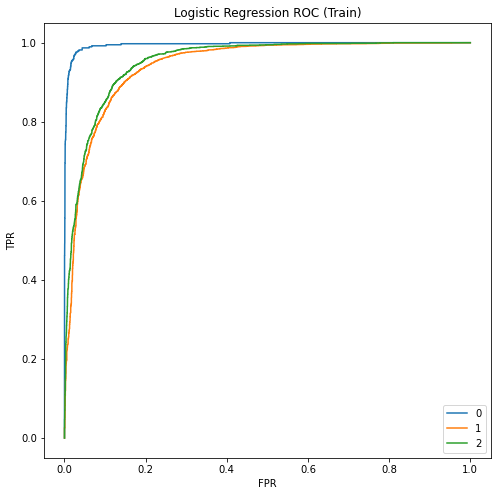

In [58]:
roc_curve_multiclass(clfs[0].decision_function(tfidf_X_train_lemmatized), 
                    label_binarize(y_train, classes=[0,1,2]),
                    title='Logistic Regression ROC (Train)')

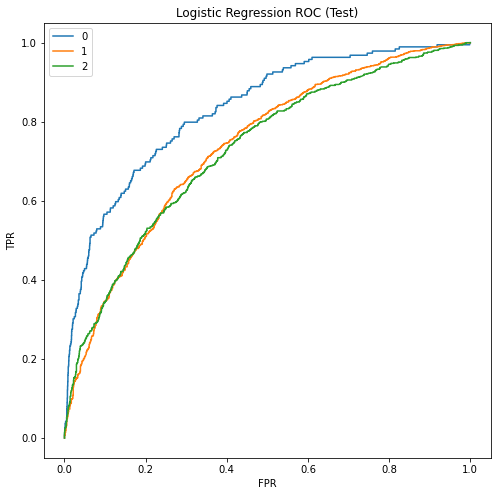

In [59]:
roc_curve_multiclass(clfs[0].decision_function(tfidf_X_test_lemmatized), 
                    label_binarize(y_test, classes=[0,1,2]),
                    title='Logistic Regression ROC (Test)')

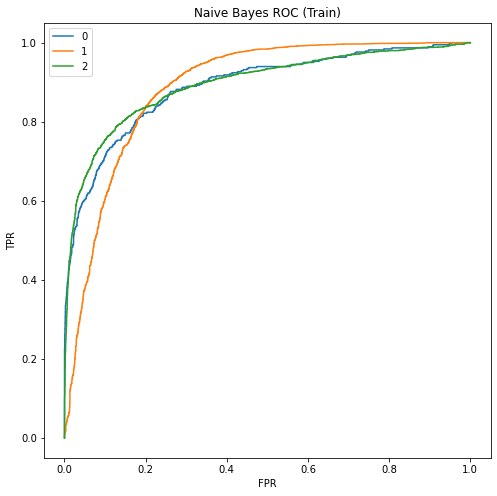

In [60]:
roc_curve_multiclass(clfs[1].predict_proba(tfidf_X_train_lemmatized), 
                    label_binarize(y_train, classes=[0,1,2]),
                    title='Naive Bayes ROC (Train)')

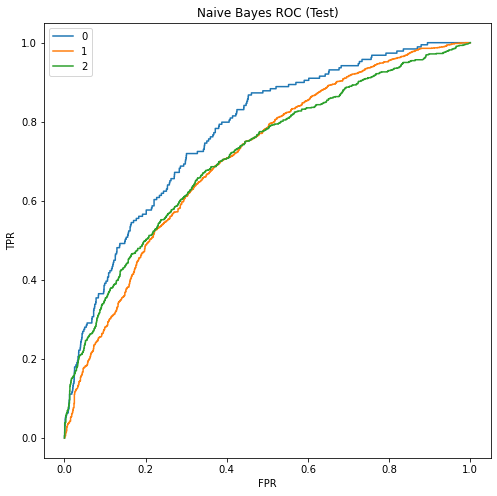

In [61]:
roc_curve_multiclass(clfs[1].predict_proba(tfidf_X_test_lemmatized), 
                    label_binarize(y_test, classes=[0,1,2]),
                    title='Naive Bayes ROC (Test)')

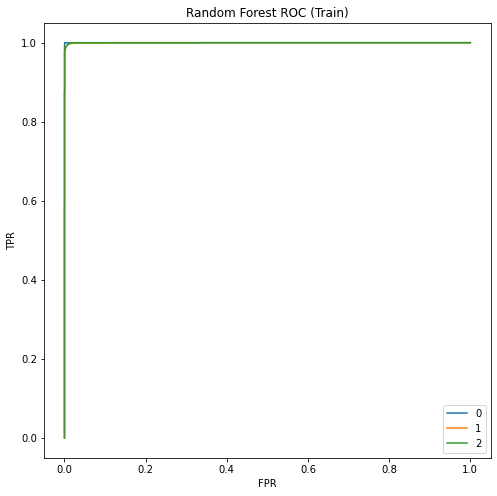

In [62]:
roc_curve_multiclass(clfs[2].predict_proba(tfidf_X_train_lemmatized), 
                     label_binarize(y_train, classes = [0, 1, 2]), 
                     title='Random Forest ROC (Train)')

Shockingly good results from the RF on train data, but...

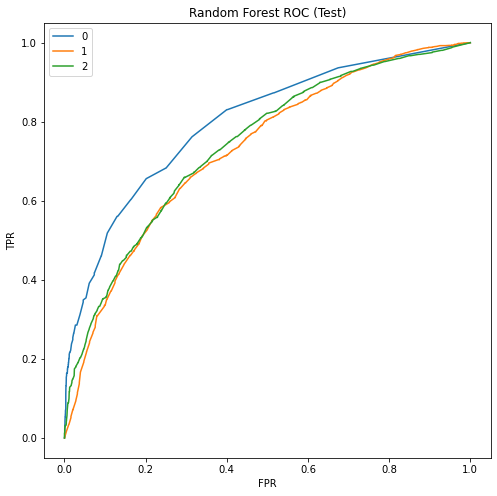

In [63]:
roc_curve_multiclass(clfs[2].predict_proba(tfidf_X_test_lemmatized), 
                     label_binarize(y_test, classes = [0, 1, 2]),
                     title='Random Forest ROC (Test)')

significantly decreased performance on test data.

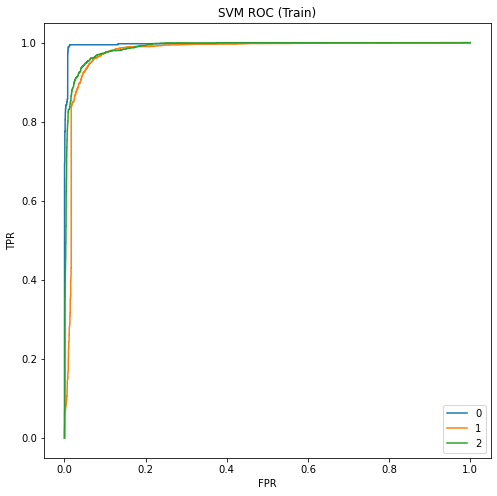

In [64]:
roc_curve_multiclass(clfs[3].decision_function(tfidf_X_train_lemmatized),
                    label_binarize(y_train, classes=[0,1,2]),
                    title='SVM ROC (Train)')

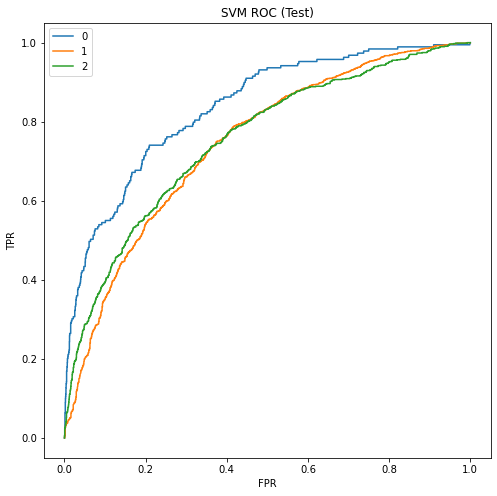

In [65]:
roc_curve_multiclass(clfs[3].decision_function(tfidf_X_test_lemmatized),
                    label_binarize(y_test, classes=[0,1,2]),
                    title='SVM ROC (Test)')

My models appear to be overfitting--model performance decreases on test data, and regardless of which model I use, I can't seem to beat ~0.53 f1 score on test data. The SVM and RF seem to perform best on train data, which might make them the best fit for this data.

Before I start tuning models, I try to reduce the dimensionality of my data to minimize model train times.

In [67]:
tsvd = TruncatedSVD(4000)
tsvd.fit(tfidf_X_train_lemmatized)

TruncatedSVD(n_components=4000)

In [68]:
tsvd.explained_variance_ratio_.cumsum()

array([0.01821521, 0.03828661, 0.04613611, ..., 0.99288093, 0.99289907,
       0.99291715])

In [69]:
dims = np.arange(1, 4001)

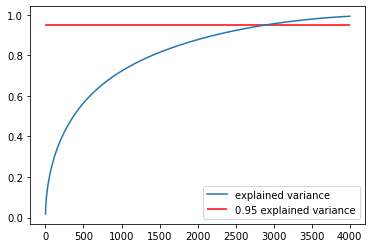

In [70]:
plt.plot(dims, tsvd.explained_variance_ratio_.cumsum(), label='explained variance')
plt.hlines(0.95, xmin=0, xmax=4000, colors='red', label='0.95 explained variance')
plt.legend()

Looks like 95% of explained variance is preserved down to ~3000 dimensions. That's a big improvement from the previous ~8000 dimensions, so I'll make that my cutoff.

In [71]:
explained_var = tsvd.explained_variance_ratio_.cumsum()
ideal_dim = 4000 - len(explained_var[explained_var >= 0.95]) + 1

tsvd = TruncatedSVD(ideal_dim)
svd_X_train_lemmatized = tsvd.fit_transform(tfidf_X_train_lemmatized)
svd_X_test_lemmatized = tsvd.transform(tfidf_X_test_lemmatized)

In [87]:
params = {
    'n_estimators': [80, 90, 100, 110],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [5]
}

clf_rf = RandomForestClassifier()
gs_rf = GridSearchCV(clf_rf, param_grid=params, scoring='f1_macro', cv=3, verbose=3)
gs_rf.fit(svd_X_train_lemmatized, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_depth=None, min_samples_split=5, n_estimators=80 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=None, min_samples_split=5, n_estimators=80, score=0.388, total=  19.1s
[CV] max_depth=None, min_samples_split=5, n_estimators=80 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.1s remaining:    0.0s


[CV]  max_depth=None, min_samples_split=5, n_estimators=80, score=0.415, total=  21.4s
[CV] max_depth=None, min_samples_split=5, n_estimators=80 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.6s remaining:    0.0s


[CV]  max_depth=None, min_samples_split=5, n_estimators=80, score=0.404, total=  17.9s
[CV] max_depth=None, min_samples_split=5, n_estimators=90 ............
[CV]  max_depth=None, min_samples_split=5, n_estimators=90, score=0.398, total=  22.2s
[CV] max_depth=None, min_samples_split=5, n_estimators=90 ............
[CV]  max_depth=None, min_samples_split=5, n_estimators=90, score=0.417, total=  22.8s
[CV] max_depth=None, min_samples_split=5, n_estimators=90 ............
[CV]  max_depth=None, min_samples_split=5, n_estimators=90, score=0.404, total=  21.9s
[CV] max_depth=None, min_samples_split=5, n_estimators=100 ...........
[CV]  max_depth=None, min_samples_split=5, n_estimators=100, score=0.392, total=  23.5s
[CV] max_depth=None, min_samples_split=5, n_estimators=100 ...........
[CV]  max_depth=None, min_samples_split=5, n_estimators=100, score=0.413, total=  28.6s
[CV] max_depth=None, min_samples_split=5, n_estimators=100 ...........
[CV]  max_depth=None, min_samples_split=5, n_estim

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 17.5min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 50],
                         'min_samples_split': [5],
                         'n_estimators': [80, 90, 100, 110]},
             scoring='f1_macro', verbose=3)

In [88]:
gs_rf.best_score_

0.4061351056243612

In [89]:
gs_rf.best_params_

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 90}

In [90]:
report(y_test, gs_rf.predict(svd_X_test_lemmatized))

[[13.2 83.6  3.2]
 [ 0.7 93.4  5.9]
 [ 0.1 78.6 21.2]]

              precision    recall  f1-score   support

           0       0.68      0.13      0.22       189
           1       0.64      0.93      0.76      1612
           2       0.65      0.21      0.32       880

    accuracy                           0.64      2681
   macro avg       0.65      0.43      0.43      2681
weighted avg       0.65      0.64      0.58      2681



**Disappointingly, the f1 score on test data––0.43––hasn't improve after the GridSearch on the RF's hyperparameters.**

In [91]:
params = {
    'Cs': [1, 3, 5, 7, 10, 15, 20],
}

clf_lr = LogisticRegressionCV(cv=5)
gs_lr = GridSearchCV(clf_lr, param_grid=params, scoring='f1_macro', cv=3, verbose=3)
gs_lr.fit(svd_X_train_lemmatized, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] Cs=1 ............................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ Cs=1, score=0.251, total=   2.6s
[CV] Cs=1 ............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] ................................ Cs=1, score=0.251, total=   2.1s
[CV] Cs=1 ............................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] ................................ Cs=1, score=0.251, total=   2.8s
[CV] Cs=3 ............................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ................................ Cs=3, score=0.469, total=  31.5s
[CV] Cs=3 ............................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ................................ Cs=3, score=0.448, total=  34.0s
[CV] Cs=3 ............................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ................................ Cs=3, score=0.449, total=  32.9s
[CV] Cs=5 ............................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ................................ Cs=5, score=0.469, total=  51.3s
[CV] Cs=5 ............................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ................................ Cs=5, score=0.448, total=  45.4s
[CV] Cs=5 ............................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ................................ Cs=5, score=0.449, total=  44.2s
[CV] Cs=7 ............................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ................................ Cs=7, score=0.469, total= 1.1min
[CV] Cs=7 ............................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ................................ Cs=7, score=0.448, total= 1.1min
[CV] Cs=7 ............................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ................................ Cs=7, score=0.449, total= 1.4min
[CV] Cs=10 ...........................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ............................... Cs=10, score=0.514, total= 1.6min
[CV] Cs=10 ...........................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ............................... Cs=10, score=0.500, total= 1.3min
[CV] Cs=10 ...........................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ............................... Cs=10, score=0.496, total= 1.4min
[CV] Cs=15 ...........................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ............................... Cs=15, score=0.514, total= 1.9min
[CV] Cs=15 ...........................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ............................... Cs=15, score=0.503, total= 2.0min
[CV] Cs=15 ...........................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ............................... Cs=15, score=0.449, total= 3.2min
[CV] Cs=20 ...........................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ............................... Cs=20, score=0.527, total= 3.8min
[CV] Cs=20 ...........................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ............................... Cs=20, score=0.472, total= 3.2min
[CV] Cs=20 ...........................................................


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

[CV] ............................... Cs=20, score=0.468, total= 3.0min


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 29.2min finished
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also ref

GridSearchCV(cv=3, estimator=LogisticRegressionCV(cv=5),
             param_grid={'Cs': [1, 3, 5, 7, 10, 15, 20]}, scoring='f1_macro',
             verbose=3)

In [100]:
gs_lr.best_params_

{'Cs': 10}

In [93]:
report(y_test, gs_lr.predict(svd_X_test_lemmatized))

[[14.3 65.6 20.1]
 [ 0.9 83.3 15.8]
 [ 0.9 50.5 48.6]]

              precision    recall  f1-score   support

           0       0.54      0.14      0.23       189
           1       0.70      0.83      0.76      1612
           2       0.59      0.49      0.53       880

    accuracy                           0.67      2681
   macro avg       0.61      0.49      0.51      2681
weighted avg       0.66      0.67      0.65      2681



**Logistic has decreased slightly to 0.51 f1 score, but looking at the confusion matrix, it's getting most of the 0-class and 2-class items wrong.** That's a pretty big error, as those are the negative and positive reviews, respectively. There is a slightly mitigating factor that they're both being mostly misclassified as 1, no emotion, but still the majority of 0-class and 2-class reviews are wrongly labeled as no sentiment.

In [120]:
clf_ann_3 = models.Sequential()
clf_ann_3.add(layers.Dense(1000, activation='relu', input_shape = (ideal_dim, )))
clf_ann_3.add(layers.Dense(500, activation='relu'))
clf_ann_3.add(layers.Dense(100, activation='relu'))
clf_ann_3.add(layers.Dense(3, activation='softmax'))
clf_ann_3.compile(optimizer='SGD', 
                loss='categorical_crossentropy',
                metrics=[get_f1])
history_3 = clf_ann_3.fit(svd_X_train_lemmatized, y_train_ohe, epochs=20, batch_size=100)

Epoch 1/20
6255/6255 [==============================] - 4s 706us/step - loss: 1.0199 - accuracy: 0.5990
Epoch 2/20
6255/6255 [==============================] - 4s 580us/step - loss: 0.9169 - accuracy: 0.6037
Epoch 3/20
6255/6255 [==============================] - 4s 591us/step - loss: 0.8750 - accuracy: 0.6037
Epoch 4/20
6255/6255 [==============================] - 4s 575us/step - loss: 0.8575 - accuracy: 0.6037
Epoch 5/20
6255/6255 [==============================] - 4s 585us/step - loss: 0.8491 - accuracy: 0.6037
Epoch 6/20
6255/6255 [==============================] - 4s 586us/step - loss: 0.8446 - accuracy: 0.6037
Epoch 7/20
6255/6255 [==============================] - 4s 591us/step - loss: 0.8419 - accuracy: 0.6037
Epoch 8/20
6255/6255 [==============================] - 5s 734us/step - loss: 0.8404 - accuracy: 0.6037
Epoch 9/20
6255/6255 [==============================] - 5s 810us/step - loss: 0.8394 - accuracy: 0.6037
Epoch 10/20
6255/6255 [==============================] - 4s 667u

In [127]:
yhat_test = clf_ann_3.predict(svd_X_test_lemmatized)
yhat_test = [np.argmax(y) for y in yhat_test]
report(y_test, yhat_test)

[[  0. 100.   0.]
 [  0. 100.   0.]
 [  0. 100.   0.]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       189
           1       0.60      1.00      0.75      1612
           2       0.00      0.00      0.00       880

    accuracy                           0.60      2681
   macro avg       0.20      0.33      0.25      2681
weighted avg       0.36      0.60      0.45      2681



/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pretty awful. Look at the confusion matrix: the model is just guessing 1 for everything. F1 score is 0.25.

In [126]:
clf_ann_4 = models.Sequential()
clf_ann_4.add(layers.Dropout(.3, input_shape=(ideal_dim, )))
clf_ann_4.add(layers.Dense(1000, activation='relu'))
clf_ann_4.add(layers.Dropout(.3))
clf_ann_4.add(layers.Dense(500, activation='relu'))
clf_ann_4.add(layers.Dropout(.3))
clf_ann_4.add(layers.Dense(100, activation='relu'))
clf_ann_4.add(layers.Dropout(.3))
clf_ann_4.add(layers.Dense(3, activation='softmax'))
clf_ann_4.compile(optimizer='SGD', 
                loss='categorical_crossentropy',
                metrics=[get_f1])
history_4 = clf_ann_4.fit(svd_X_train_lemmatized, y_train_ohe, epochs=20, batch_size=100)

Epoch 1/20
6255/6255 [==============================] - 8s 1ms/step - loss: 1.0190 - accuracy: 0.5880
Epoch 2/20
6255/6255 [==============================] - 7s 1ms/step - loss: 0.9230 - accuracy: 0.6037
Epoch 3/20
6255/6255 [==============================] - 6s 1ms/step - loss: 0.8791 - accuracy: 0.6037
Epoch 4/20
6255/6255 [==============================] - 7s 1ms/step - loss: 0.8611 - accuracy: 0.6037
Epoch 5/20
6255/6255 [==============================] - 7s 1ms/step - loss: 0.8533 - accuracy: 0.6037
Epoch 6/20
6255/6255 [==============================] - 8s 1ms/step - loss: 0.8476 - accuracy: 0.6037
Epoch 7/20
6255/6255 [==============================] - 9s 1ms/step - loss: 0.8465 - accuracy: 0.6037
Epoch 8/20
6255/6255 [==============================] - 7s 1ms/step - loss: 0.8463 - accuracy: 0.6037
Epoch 9/20
6255/6255 [==============================] - 7s 1ms/step - loss: 0.8437 - accuracy: 0.6037
Epoch 10/20
6255/6255 [==============================] - 6s 959us/step - loss: 0.8

In [128]:
yhat_test = clf_ann_4.predict(svd_X_test_lemmatized)
yhat_test = [np.argmax(y) for y in yhat_test]
report(y_test, yhat_test)

[[  0. 100.   0.]
 [  0. 100.   0.]
 [  0. 100.   0.]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       189
           1       0.60      1.00      0.75      1612
           2       0.00      0.00      0.00       880

    accuracy                           0.60      2681
   macro avg       0.20      0.33      0.25      2681
weighted avg       0.36      0.60      0.45      2681



Same problem as before. It's at this point that the support column of the classification report above is catching my eye. There are 189 "0" labels, but 1612 "1" labels. The difference is nearly 1:10, so below I try implementing SMOTE to see if that improves things.

In [95]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(svd_X_train_lemmatized, y_train_ohe)

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [131]:
clf_ann_5 = models.Sequential()
clf_ann_5.add(layers.Dense(1000, activation='relu', input_shape = (ideal_dim, )))
clf_ann_5.add(layers.Dense(500, activation='relu'))
clf_ann_5.add(layers.Dense(100, activation='relu'))
clf_ann_5.add(layers.Dense(3, activation='softmax'))
clf_ann_5.compile(optimizer='SGD', 
                loss='categorical_crossentropy',
                metrics=[get_f1])
history_5 = clf_ann_5.fit(X_res, y_res, epochs=20, batch_size=100)

Epoch 1/20
11328/11328 [==============================] - 7s 658us/step - loss: 1.0979 - accuracy: 0.3403
Epoch 2/20
11328/11328 [==============================] - 7s 586us/step - loss: 1.0963 - accuracy: 0.4127
Epoch 3/20
11328/11328 [==============================] - 7s 584us/step - loss: 1.0948 - accuracy: 0.4496
Epoch 4/20
11328/11328 [==============================] - 7s 590us/step - loss: 1.0933 - accuracy: 0.4889
Epoch 5/20
11328/11328 [==============================] - 7s 604us/step - loss: 1.0917 - accuracy: 0.5273
Epoch 6/20
11328/11328 [==============================] - 7s 639us/step - loss: 1.0900 - accuracy: 0.5272
Epoch 7/20
11328/11328 [==============================] - 7s 591us/step - loss: 1.0883 - accuracy: 0.55320s - loss:
Epoch 8/20
11328/11328 [==============================] - 7s 592us/step - loss: 1.0863 - accuracy: 0.5674
Epoch 9/20
11328/11328 [==============================] - 7s 583us/step - loss: 1.0842 - accuracy: 0.5783
Epoch 10/20
11328/11328 [===========

In [132]:
yhat_test = clf_ann_5.predict(svd_X_test_lemmatized)
yhat_test = [np.argmax(y) for y in yhat_test]
report(y_test, yhat_test)

[[75.1 13.2 11.6]
 [29.8 45.3 24.9]
 [35.8 28.4 35.8]]

              precision    recall  f1-score   support

           0       0.15      0.75      0.25       189
           1       0.73      0.45      0.56      1612
           2       0.43      0.36      0.39       880

    accuracy                           0.44      2681
   macro avg       0.44      0.52      0.40      2681
weighted avg       0.59      0.44      0.48      2681



Big improvement. The f1 score is up to 0.4 from 0.25. Still not a great score, though. Next I try whittling down my model a bit.

In [135]:
clf_ann_6 = models.Sequential()
clf_ann_6.add(layers.Dropout(.3, input_shape=(ideal_dim, )))
clf_ann_6.add(layers.Dense(1000, activation='relu'))
clf_ann_6.add(layers.Dropout(.3))
clf_ann_6.add(layers.Dense(500, activation='relu'))
clf_ann_6.add(layers.Dropout(.3))
clf_ann_6.add(layers.Dense(100, activation='relu'))
clf_ann_6.add(layers.Dropout(.3))
clf_ann_6.add(layers.Dense(3, activation='softmax'))
clf_ann_6.compile(optimizer='SGD', 
                loss='categorical_crossentropy',
                metrics=[get_f1])
history_6 = clf_ann_6.fit(X_res, y_res, epochs=120, batch_size=100)

Epoch 1/120
11328/11328 [==============================] - 13s 1ms/step - loss: 1.0985 - accuracy: 0.3419
Epoch 2/120
11328/11328 [==============================] - 12s 1ms/step - loss: 1.0979 - accuracy: 0.3508
Epoch 3/120
11328/11328 [==============================] - 13s 1ms/step - loss: 1.0973 - accuracy: 0.3600
Epoch 4/120
11328/11328 [==============================] - 12s 1ms/step - loss: 1.0968 - accuracy: 0.3678
Epoch 5/120
11328/11328 [==============================] - 11s 1ms/step - loss: 1.0958 - accuracy: 0.3829
Epoch 6/120
11328/11328 [==============================] - 11s 1ms/step - loss: 1.0947 - accuracy: 0.3939
Epoch 7/120
11328/11328 [==============================] - 11s 1ms/step - loss: 1.0942 - accuracy: 0.3986
Epoch 8/120
11328/11328 [==============================] - 12s 1ms/step - loss: 1.0927 - accuracy: 0.4116
Epoch 9/120
11328/11328 [==============================] - 12s 1ms/step - loss: 1.0912 - accuracy: 0.4220
Epoch 10/120
11328/11328 [====================

In [136]:
yhat_test = clf_ann_6.predict(svd_X_test_lemmatized)
yhat_test = [np.argmax(y) for y in yhat_test]
report(y_test, yhat_test)

[[60.3 13.8 25.9]
 [ 9.2 48.7 42.1]
 [10.2 17.7 72. ]]

              precision    recall  f1-score   support

           0       0.32      0.60      0.42       189
           1       0.81      0.49      0.61      1612
           2       0.47      0.72      0.57       880

    accuracy                           0.57      2681
   macro avg       0.53      0.60      0.53      2681
weighted avg       0.66      0.57      0.58      2681



Adding some dropout layers to my ANN improved the f1 significantly, now at 0.53 on test data. Importantly, looking at the confusion matrix shows that for each class, it correctly predicts that class more than any other: 60% of 0's are accurately predicted, 49% of 1's are accurately predicted, and 72% of 2's are accurately predicted.

The biggest mistake the ANN is making now is classifying 42% of 1's as 2's. In other words, 42% of reviews with no emotion are being categorized as positive.

In [96]:
# had to rerun SMOTE on the non-OHE version of y_train for the following models
X_res, y_res = smote.fit_resample(svd_X_train_lemmatized, y_train)

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [97]:
params = {
    'n_estimators': [80, 90, 100, 110],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [5]
}

clf_rf = RandomForestClassifier()
gs_rf = GridSearchCV(clf_rf, param_grid=params, scoring='f1_macro', cv=3, verbose=3)
gs_rf.fit(X_res, y_res)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_depth=None, min_samples_split=5, n_estimators=80 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=None, min_samples_split=5, n_estimators=80, score=0.798, total=  34.7s
[CV] max_depth=None, min_samples_split=5, n_estimators=80 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.7s remaining:    0.0s


[CV]  max_depth=None, min_samples_split=5, n_estimators=80, score=0.794, total=  36.3s
[CV] max_depth=None, min_samples_split=5, n_estimators=80 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV]  max_depth=None, min_samples_split=5, n_estimators=80, score=0.842, total=  34.0s
[CV] max_depth=None, min_samples_split=5, n_estimators=90 ............
[CV]  max_depth=None, min_samples_split=5, n_estimators=90, score=0.786, total=  38.1s
[CV] max_depth=None, min_samples_split=5, n_estimators=90 ............
[CV]  max_depth=None, min_samples_split=5, n_estimators=90, score=0.805, total=  41.1s
[CV] max_depth=None, min_samples_split=5, n_estimators=90 ............
[CV]  max_depth=None, min_samples_split=5, n_estimators=90, score=0.852, total=  44.5s
[CV] max_depth=None, min_samples_split=5, n_estimators=100 ...........
[CV]  max_depth=None, min_samples_split=5, n_estimators=100, score=0.788, total=  43.2s
[CV] max_depth=None, min_samples_split=5, n_estimators=100 ...........
[CV]  max_depth=None, min_samples_split=5, n_estimators=100, score=0.818, total=  43.0s
[CV] max_depth=None, min_samples_split=5, n_estimators=100 ...........
[CV]  max_depth=None, min_samples_split=5, n_estim

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 32.0min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 50],
                         'min_samples_split': [5],
                         'n_estimators': [80, 90, 100, 110]},
             scoring='f1_macro', verbose=3)

In [99]:
gs_rf.best_params_

{'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 110}

In [98]:
report(y_test, gs_rf.predict(svd_X_test_lemmatized))

[[20.1 59.3 20.6]
 [ 1.6 79.4 19. ]
 [ 0.6 57.  42.4]]

              precision    recall  f1-score   support

           0       0.55      0.20      0.29       189
           1       0.68      0.79      0.73      1612
           2       0.52      0.42      0.47       880

    accuracy                           0.63      2681
   macro avg       0.58      0.47      0.50      2681
weighted avg       0.62      0.63      0.61      2681



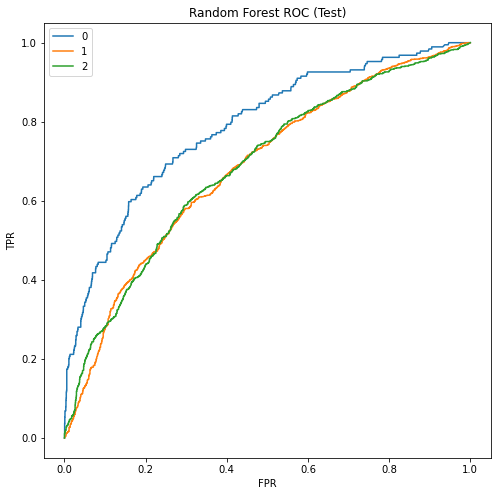

In [105]:
roc_curve_multiclass(gs_rf.predict_proba(svd_X_test_lemmatized), 
                    label_binarize(y_test, classes=[0,1,2]),
                    title='Random Forest ROC (Test)')

Still not much improvement on the RF even using SMOTEd train data, but we can tell it does best corrrectly classifying negative reviews. I've got to throw in the hat on it for now. 

## Results 

The neural network, random forest, and logistic regression models seems to be faring best. With more time, it might be a good idea to check out more forest models, like AdaBoost or XGBoost.

|Model|Initial (Test) F1|**Best (Test) F1**|
|---|---|---|
| Neural Network | 0.25 | 0.53 |
| Logistic Regressions | 0.53 | 0.53 |
| Random Forest | 0.49 | 0.51 |
| Support Vector Machine | 0.47 | 0.48 |
| Naive Bayes Classifier | 0.37 | 0.38 |
|  |  |  |

## Conclusions

The hardest part about this project has turned out to be the three-way classification problem as well as class imbalance, approximately 10:1 in the case of classes '1' and '0'. At present, the most informative component of this analysis seems to be the purely exploratory: dividing data into groups by sentiment (positive, negative, none) and inspecting most common tokens from there. That line of inquiry yielded some interesting insights, particularly when comparing between positive and negative reviews. For example, exclamation marks are one of the top 40 most common (filtered) tokens among positive reviews, as were "great," "social," and "new"; meanwhile, "need," "headaches," and "long" and "line" were in the top 40 most common for negative reviews.

As a "black box" model for discerning review sentiment, these models don't yet appear very impressive, with the very best models producing **~0.53 macro f1 score on test data**. Decent, but not terribly impressive. ROC curves revealed that across the board models were best at identifying negative reviews. F1 scores for this project were achieved by the following steps:

1. Preprocess data

 a. Lowercase all reviews
  
 b. Break reviews into individual tokens
  
 c. Remove all punctuation (except exclamation points) and stop words from tokens
  
 d. Lemmatize tokens
  
 e. Vectorize with tf-idf
  
 f. Reduce dimensions with TSVD
  
 g. Resample using SMOTE
  
  
2.  Train models. Caution: I trained my models without a validation set, so be aware of that when interpretting my results; I should have, but forgot. Best hyperparameters for each model were as follows:

 RF:  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 90}
  
 LogRegCV: {'Cs': 10}
  
 SVM: out of the box
  
 Multinomial Naive Bayes:  out of the box
  
 ANN: 3 hidden layers of 1000, 500, and 100; all with ReLU activation, except softmax on the output layer; and 30% dropout at each layer.
